<a href="https://colab.research.google.com/github/IgorBaratta/FEniCSxCourse/blob/ICMC23/Problem7_Helmholtz/helmholtz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import gmsh
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
  import gmsh

try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

try:
  import pyvista
except ImportError:
  !pip install -q piglet pyvirtualdisplay ipyvtklink pyvista panel pythreejs
  !apt-get -qq install xvfb
  import pyvista

!wget "https://raw.githubusercontent.com/IgorBaratta/FEniCSxCourse/main/Problem7_Helmholtz/utils.py"
!wget "https://raw.githubusercontent.com/IgorBaratta/FEniCSxCourse/main/Problem7_Helmholtz/mesh_generation.py"

--2023-02-01 18:27:53--  https://raw.githubusercontent.com/IgorBaratta/FEniCSxCourse/main/Problem7_Helmholtz/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2905 (2.8K) [text/plain]
Saving to: ‘utils.py.8’

utils.py.8          100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-02-01 18:27:54 (31.7 MB/s) - ‘utils.py.8’ saved [2905/2905]

--2023-02-01 18:27:54--  https://raw.githubusercontent.com/IgorBaratta/FEniCSxCourse/main/Problem7_Helmholtz/mesh_generation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

# The Helmholtz equation

In this tutorial, we will learn:
- How to solve PDEs with complex-valued fields,
- How to import and use high-order meshes from Gmsh,
- How to use high order discretizations,
- How to use UFL expressions.

## Problem statement

The Helmholtz equation can be used to model the scattering of time-harmonic waves by finite and infinite obstacles.
We will solve the Helmholtz equation subject to a first order absorbing boundary condition:
$$
\begin{align*}
\Delta u + k^2 u &= 0 && \text{in } \Omega,\\
\nabla u \cdot \mathbf{n} - \mathrm{j}ku &= g && \text{on } \partial\Omega,
\end{align*}
$$

where $k$ is a piecewise constant wavenumber, $\mathrm{j}=\sqrt{-1}$, and $g$ is the boundary source term computed as

$$g = \nabla u_\text{inc} \cdot \mathbf{n} - \mathrm{j}ku_\text{inc}$$


The second equation on $\partial\Omega$ is a mixed boundary condition, or a Robin boundary condition.

 To derive the weak form for the Helmholtz's equation, we first multiply both sides
of the equation with the complex conjugate of a sufficiently smooth arbitrary test
function $v$, integrate by parts in $\Omega$, the domain of interest, and after
applying the divergence theorem, we find
$$
\begin{align*}
    -\int_\Omega \nabla u \cdot \nabla \bar{v} ~ dx + \int_\Omega k^2 u \,\bar{v} ~ dx + \int_{\partial \Omega} \left(\nabla u \cdot \mathbf{n} \right) \bar{v} ~ ds = \int_\Omega f \, \bar{v} ~ dx.
\end{align*}
$$

Assuming that $u$ is a classical solution of our original equation with suitable
boundary conditions, it is also a solution of the weak form for any $v \in C_0^1(\Omega)$,
nevertheless with a reduced smoothness requirement.
If $\Omega \in \mathbb{R}^d, \, d = 1, 2, 3 \,$, then the natural space for the
weak solution and the test functions $v$ is the Sobolev space
$\mathcal{H}^1 (\Omega)$, given by
\begin{equation}
    \mathcal{H}^1(\Omega) := \{ u: \Omega \rightarrow \mathbb{C}|\,  u \in L^2(\Omega),\,  \partial_{x_i}u\in L^2(\Omega), 1\leq i \leq d  \}.
\end{equation}

Assuming that the test function $v$ vanishes on $\Gamma_D$, where
the solution $u$ is known, we arrive at the following variational problem:

Find $u \in V$ such that
$$
\begin{align*}
    -\int_\Omega \nabla u \cdot \nabla \bar{v} ~ dx + \int_\Omega k^2 u \,\bar{v}~ dx + \int_{\partial \Omega / \Gamma_D} \left(\nabla u \cdot \mathbf{n} \right) \bar{v} ~ ds = \int_\Omega f \, \bar{v}~ dx \qquad \forall v \in V_0.
\end{align*}
$$

Standard Galerkin finite element solutions with low-order piecewise polynomials differ significantly from the best approximation, due to spurious dispersion in the computation, unless the mesh is sufficiently refined. This phenomenon, related to the indefiniteness of the Helmholtz operator is known as the pollution effect.


In [2]:
from utils import penetrable_circle
from dolfinx import geometry
import matplotlib.pyplot as plt
import dolfinx.cpp as _cpp
from dolfinx.io import XDMFFile, VTXWriter
from mpi4py import MPI

# utils for plotting and generating mesh
from utils import plot_mesh
from mesh_generation import generate_mesh

# Auxiliary libraries
import IPython
import numpy as np

# Import dolfinx modules and ufl
import dolfinx
from dolfinx.io import gmshio
import ufl

This example is designed to be executed with complex-valued coefficients.
To be able to solve this problem, we use the complex build of PETSc.

In [3]:
import sys
from petsc4py import PETSc

if not np.issubdtype(PETSc.ScalarType, np.complexfloating):
    print("This tutorial requires complex number support")
    sys.exit(0)
else:
    print(f"Using {PETSc.ScalarType}.")

Using <class 'numpy.complex128'>.


## Defining model parameters

Wavenumber:
$$ k_0 = \frac{2\pi}{λ} $$

$$ \nu = \frac{c_0}{\lambda} $$


The complex values wavenumber for a medium can be expressed as 
$$
k = n \cdot k_0
$$

In [4]:
# wavenumber in free space (air)
k0 = 5

# Corresponding wavelength
lmbda = 2 * np.pi / k0

# scatterer radius
radius = 2*lmbda

# refractive index of scatterer
ref_ind = 1.2

# Polynomial degree
degree = 5

# width of computational domain
dim_x = 10*lmbda

# Mesh order
mesh_order = 2

In [5]:
# For this problem we use a square mesh with triangular elements.
# The mesh element size is h_elem, and the #elements in one dimension is n_elem
h_elem = lmbda / 5

The rules of thumb in engineering practice dictates that with a constant $kh$ the error remains constant.

However the error estimates include a second term
$$
e \leq C_1 \left(\frac{kh}{2p} \right)^p + C_2 k  \left(\frac{kh}{2p} \right)^{2p}
$$
which dominates the error for high-frequency problems, so keeping $kh = const$ may lead to corrupted solutions.

For example, for $P=1$
$$
e \leq C_1 \frac{kh}{2} + C_2 k  \left(\frac{kh}{2} \right)^2
$$

## Interfacing with GMSH
We will use Gmsh to generate the computational domain (mesh) for this example.
As long as Gmsh has been installed (including its Python API), DOLFINx supports direct input of Gmsh models (generated on one process).
DOLFINx will then in turn distribute the mesh over all processes in the communicator passed to `dolfinx.io.gmshio.model_to_mesh`.

The function `generate_mesh` creates a Gmsh model and saves it into a `.msh` file.

In [6]:

# MPI communicator
comm = MPI.COMM_WORLD

file_name = "domain.msh"
generate_mesh(file_name, radius, dim_x, h_elem, mesh_order)

Now we can read the mesh from file:

In [7]:
mesh, cell_tags, _ = gmshio.read_from_msh(file_name, comm, rank=0, gdim=2)

num_cells = mesh.topology.index_map(2).size_global
h = _cpp.mesh.h(mesh, 2, range(num_cells))
print(num_cells, h.max(), h_elem)

10520 0.2584168650079171 0.25132741228718347


## Material parameters
In this problem, the wave number in the different parts of the domain
depends on cell markers, inputted through `cell_tags`. We use the fact that a
discontinuous Lagrange space of order 0 (cell-wise constants) has a
one-to-one mapping with the cells local to the process.

In [8]:
W = dolfinx.fem.FunctionSpace(mesh, ("DG", 0))
k = dolfinx.fem.Function(W)
k.x.array[:] = k0
k.x.array[cell_tags.find(1)] = ref_ind*k0

plot_mesh(mesh, cell_values=k, filename="mesh.html")
IPython.display.HTML(filename="mesh.html")

  self.SetScalarRange(*clim)



## Boundary source term
$$g = \nabla u_{inc} \cdot \mathbf{n} - \mathrm{j}ku_{inc}$$
where $u_{inc} = e^{-jkx}$ the incoming wave, is a plane wave propagating
in the $x$ direction.

Next, we define the boundary source term by using `ufl.SpatialCoordinate`.
When using this function, all quantities using this expression will be evaluated
at quadrature points.

In [9]:
n = ufl.FacetNormal(mesh)
x = ufl.SpatialCoordinate(mesh)
uinc = ufl.exp(-1j * k0 * x[0])
g = ufl.dot(ufl.grad(uinc), n) + 1j * k0 * uinc

## Variational form
Next, we define the variational problem using a 6th order Lagrange space.
Note that as we are using complex valued functions, we have to use the
appropriate inner product; see DOLFINx tutorial: Complex numbers for more
information.

Find $u \in V$ such that
$$-\int_\Omega \nabla u \cdot \nabla \bar{v} ~ dx + \int_\Omega k^2 u \,\bar{v}~ dx - j\int_{\partial \Omega} ku  \bar{v} ~ ds = \int_{\partial \Omega} g \, \bar{v}~ ds \qquad \forall v \in \widehat{V}.$$

In [10]:
element = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), degree)
V = dolfinx.fem.FunctionSpace(mesh, element)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [11]:
a = - ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx \
    + k**2 * ufl.inner(u, v) * ufl.dx \
    + 1j * k * ufl.inner(u, v) * ufl.ds
L = ufl.inner(g, v) * ufl.ds

## Linear solver
Next, we will solve the problem using a direct solver (LU).
Contrary to the case of elliptic problems where effective multigrid
and domain decomposition methods are readily available
(see for example PETSc documentation), the solution of $Au=b$ is less understood.

The matrix inherits many characteristics from the original equations;
it is symmetric unless non-reciprocal materials are used, and generally,
it is not positive definite nor hermitian.

In [12]:
opt = {"ksp_type": "preonly", "pc_type": "lu"}
problem = dolfinx.fem.petsc.LinearProblem(a, L, petsc_options=opt)
uh = problem.solve()
uh.name = "u"

We can compute the L2 norm of the error:

In [13]:
uex = ufl.exp(-1j * k0 * x[0])
error = uh - uex
M = dolfinx.fem.form(ufl.inner(uh, uh)*ufl.dx)
errorL2 = dolfinx.fem.assemble_scalar(M)

print("    |-L2error=", np.sqrt(errorL2))

    |-L2error= (12.856972838994242+0j)


## Visualizing the solution:

### Post-processing with Paraview

Using XDMFFile:

In [14]:
# XDMF writes data to mesh nodes
with XDMFFile(comm, "out.xdmf", "w") as file:
    file.write_mesh(mesh)
    file.write_function(uh)


from google.colab import files
files.download('out.xdmf')
files.download('out.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Using VTXWriter

In [15]:
with VTXWriter(comm, "out.bp", [uh]) as f:
    f.write(0.0)

!zip -r out.zip out.bp

from google.colab import files
files.download('out.zip') 

updating: out.bp/ (stored 0%)
updating: out.bp/md.0 (deflated 64%)
updating: out.bp/profiling.json (deflated 43%)
updating: out.bp/md.idx (deflated 52%)
updating: out.bp/data.0 (deflated 44%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Using matplotlib


In [16]:
# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(dim_x/lmbda * 10))
extent = [-dim_x/2, dim_x/2, -dim_x/2, dim_x/2]
xmin, xmax, ymin, ymax = extent
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Nx * 1j]
points = np.column_stack((plot_grid[0].ravel(),
                          plot_grid[1].ravel(),
                          np.zeros(plot_grid[0].size))) 

print(points)

[[-6.28318531 -6.28318531  0.        ]
 [-6.28318531 -6.15625227  0.        ]
 [-6.28318531 -6.02931923  0.        ]
 ...
 [ 6.28318531  6.02931923  0.        ]
 [ 6.28318531  6.15625227  0.        ]
 [ 6.28318531  6.28318531  0.        ]]


In [17]:
# Compute values at points
tree = geometry.BoundingBoxTree(mesh, 2)
cell_candidates = geometry.compute_collisions(tree, points)
colliding_cells = geometry.compute_colliding_cells(
    mesh, cell_candidates, points)
ncells = colliding_cells.num_nodes
cells = [colliding_cells.links(i)[0] for i in range(ncells)]
u_total = uh.eval(points, cells).reshape((Nx, Nx))

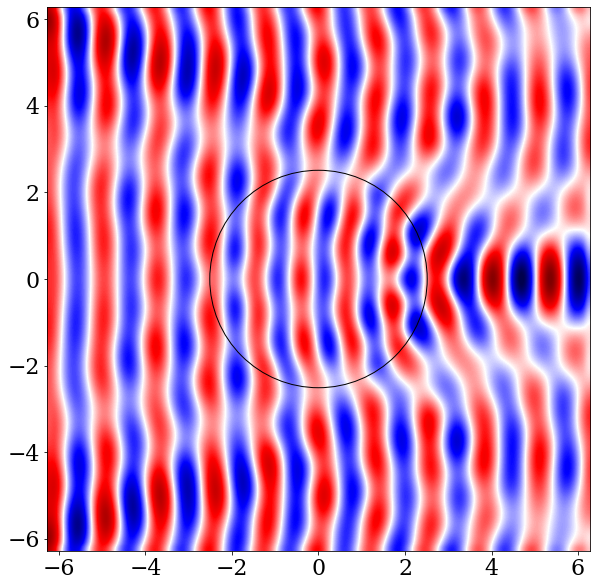

In [18]:
plt.rc('font', family='serif', size=22)
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(np.real(u_total).T, extent=extent,
           cmap=plt.cm.get_cmap('seismic'), 
           interpolation='spline16')
# Add circle
circle = plt.Circle((0., 0.), radius, color='black', fill=False)
ax.add_artist(circle)

# Homework:

In [ ]:
def helmoltz_solver(h, p, k):
  import math
  N = math.ceil(1/h)
  mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, N, N)
  element = ufl.FiniteElement("Lagrange", ufl.triangle, p)
  n = ufl.FacetNormal(mesh)

  # Definition of function space
  V = dolfinx.fem.FunctionSpace(mesh, element)

  # Incoming wave
  ui = dolfinx.fem.Function(V)
  ui.interpolate(lambda x: np.exp(1.0j * k0 * x[0]))
  g = ufl.dot(ufl.grad(ui), n) + 1j * k0 * ui

  # Define variational problem
  u = ufl.TrialFunction(V)
  v = ufl.TestFunction(V)

  # Weak Form
  a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx \
      - k0**2 * ufl.inner(u, v) * ufl.dx \
      + 1j * k0 * ufl.inner(u, v) * ufl.ds
  L = ufl.inner(g, v) * ufl.ds

  opt = {"ksp_type": "preonly", "pc_type": "lu"}
  problem = dolfinx.fem.petsc.LinearProblem(a, L, petsc_options=opt)
  uh = problem.solve()
  uh.name = "u"

  error = ui - uh
  M = ufl.inner(error, error) * ufl.dx
  error_sq = dolfinx.fem.assemble_scalar(dolfinx.fem.form(M))
  return np.sqrt(error_sq, dtype=float)

In [ ]:
p = 2
k0 = 10 * np.pi

h_list = [0.1, 0.01, 0.001, 0.001]

for h in h_list:
  e = helmoltz_solver(h, p, k)
  print(e)